In [1]:
import numpy as np
import pandas as pd
import vectorbt as vbt

In [2]:
split_kwargs = dict(
    n=30, 
    window_len=365 * 2, 
    set_lens=(180,), 
    left_to_right=False
)  # 30 windows, each 2 years long, reserve 180 days for test
pf_kwargs = dict(
    direction='all',  # long and short
    freq='d'
)
windows = np.arange(10, 50)

In [3]:
price = vbt.YFData.download('BTC-USD').get('Close')

In [4]:
print(price)

Date
2014-09-17 00:00:00+00:00      457.334015
2014-09-18 00:00:00+00:00      424.440002
2014-09-19 00:00:00+00:00      394.795990
2014-09-20 00:00:00+00:00      408.903992
2014-09-21 00:00:00+00:00      398.821014
                                 ...     
2021-07-28 00:00:00+00:00    39995.906250
2021-07-29 00:00:00+00:00    40008.421875
2021-07-30 00:00:00+00:00    42235.546875
2021-07-31 00:00:00+00:00    41626.195312
2021-08-01 00:00:00+00:00    41547.117188
Name: Close, Length: 2507, dtype: float64


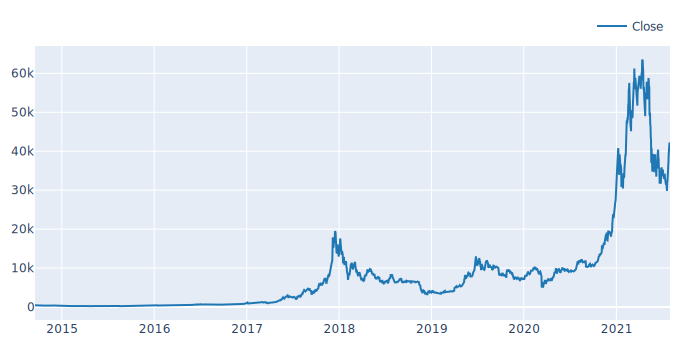

In [5]:
price.vbt.plot().show_svg()

In [6]:
def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

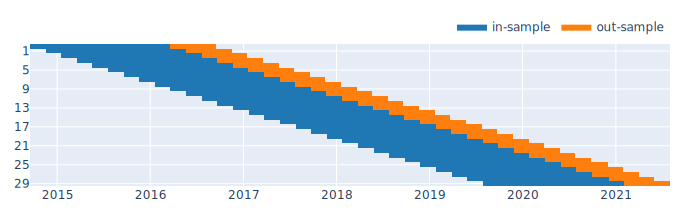

In [7]:
roll_in_and_out_samples(price, **split_kwargs, plot=True, trace_names=['in-sample', 'out-sample']).show_svg()

In [8]:
(in_price, in_indexes), (out_price, out_indexes) = roll_in_and_out_samples(price, **split_kwargs)

print(in_price.shape, len(in_indexes))  # in-sample
print(out_price.shape, len(out_indexes))  # out-sample

(550, 30) 30
(180, 30) 30


In [9]:
def simulate_holding(price, **kwargs):
    pf = vbt.Portfolio.from_holding(price, **kwargs)
    return pf.sharpe_ratio()

In [10]:
in_hold_sharpe = simulate_holding(in_price, **pf_kwargs)

print(in_hold_sharpe)

split_idx
0     0.229171
1     0.449998
2     1.601063
3     1.308247
4     1.724180
5     1.655244
6     2.047643
7     2.545951
8     2.349842
9     2.430171
10    3.014641
11    2.638306
12    2.401355
13    2.087606
14    2.009798
15    1.858262
16    0.789906
17    0.693215
18    0.499107
19    0.467097
20    0.237548
21    0.397018
22    0.359669
23    0.417747
24    0.294617
25    1.202716
26    1.397991
27    1.252581
28    1.158597
29    1.596662
Name: sharpe_ratio, dtype: float64


In [11]:
def simulate_all_params(price, windows, **kwargs):
    fast_ma, slow_ma = vbt.MA.run_combs(price, windows, r=2, short_names=['fast', 'slow'])
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return pf.sharpe_ratio()

In [12]:
# Simulate all params for in-sample ranges
in_sharpe = simulate_all_params(in_price, windows, **pf_kwargs)

print(in_sharpe)

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:670: RuntimeWarning:

invalid value encountered in greater

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:670: RuntimeWarning:

invalid value encountered in less



fast_window  slow_window  split_idx
10           11           0            0.856870
                          1            1.113133
                          2            0.496616
                          3            0.342799
                          4            0.770518
                                         ...   
48           49           25          -0.050013
                          26          -0.204703
                          27          -0.862195
                          28          -1.013760
                          29          -0.767927
Name: sharpe_ratio, Length: 23400, dtype: float64


In [13]:
def get_best_index(performance, higher_better=True):
    if higher_better:
        return performance[performance.groupby('split_idx').idxmax()].index
    return performance[performance.groupby('split_idx').idxmin()].index

In [14]:
in_best_index = get_best_index(in_sharpe)

print(in_best_index)

MultiIndex([(27, 29,  0),
            (27, 29,  1),
            (21, 25,  2),
            (23, 25,  3),
            (23, 25,  4),
            (28, 48,  5),
            (41, 42,  6),
            (37, 43,  7),
            (31, 45,  8),
            (10, 21,  9),
            (10, 21, 10),
            (10, 21, 11),
            (10, 21, 12),
            (10, 21, 13),
            (10, 21, 14),
            (10, 22, 15),
            (10, 22, 16),
            (10, 22, 17),
            (17, 22, 18),
            (18, 21, 19),
            (13, 21, 20),
            (13, 21, 21),
            (18, 21, 22),
            (18, 21, 23),
            (18, 21, 24),
            (13, 21, 25),
            (13, 20, 26),
            (13, 20, 27),
            (13, 20, 28),
            (13, 20, 29)],
           names=['fast_window', 'slow_window', 'split_idx'])


In [15]:
def get_best_params(best_index, level_name):
    return best_index.get_level_values(level_name).to_numpy()

In [16]:
in_best_fast_windows = get_best_params(in_best_index, 'fast_window')
in_best_slow_windows = get_best_params(in_best_index, 'slow_window')
in_best_window_pairs = np.array(list(zip(in_best_fast_windows, in_best_slow_windows)))

print(in_best_window_pairs)

[[27 29]
 [27 29]
 [21 25]
 [23 25]
 [23 25]
 [28 48]
 [41 42]
 [37 43]
 [31 45]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 22]
 [10 22]
 [10 22]
 [17 22]
 [18 21]
 [13 21]
 [13 21]
 [18 21]
 [18 21]
 [18 21]
 [13 21]
 [13 20]
 [13 20]
 [13 20]
 [13 20]]


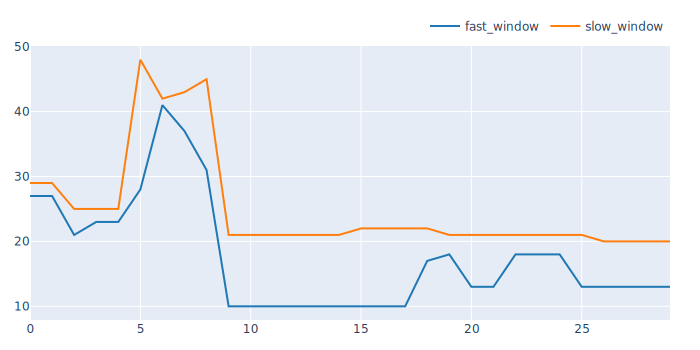

In [17]:
pd.DataFrame(in_best_window_pairs, columns=['fast_window', 'slow_window']).vbt.plot().show_svg()

In [18]:
out_hold_sharpe = simulate_holding(out_price, **pf_kwargs)

print(out_hold_sharpe)

split_idx
0     1.773721
1     2.097769
2     1.183016
3     1.967173
4     3.313528
5     3.050296
6     3.485130
7     3.021732
8     3.180476
9     2.143830
10    0.648024
11   -0.477665
12   -0.500875
13   -1.409454
14   -2.235156
15   -1.247427
16    2.342504
17    3.004826
18    2.599555
19   -0.061737
20   -0.142031
21   -0.033974
22    0.874355
23    0.608017
24    2.186908
25    2.922866
26    3.713368
27    4.863816
28    1.977284
29    0.669581
Name: sharpe_ratio, dtype: float64


In [19]:
# Simulate all params for out-sample ranges
out_sharpe = simulate_all_params(out_price, windows, **pf_kwargs)

print(out_sharpe)

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:670: RuntimeWarning:

invalid value encountered in greater

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:670: RuntimeWarning:

invalid value encountered in less



fast_window  slow_window  split_idx
10           11           0           -1.018512
                          1           -0.491385
                          2            0.461037
                          3            1.014513
                          4            2.453574
                                         ...   
48           49           25          -1.048689
                          26           2.302437
                          27           3.652679
                          28           1.250960
                          29          -0.397038
Name: sharpe_ratio, Length: 23400, dtype: float64


In [20]:
def simulate_best_params(price, best_fast_windows, best_slow_windows, **kwargs):
    fast_ma = vbt.MA.run(price, window=best_fast_windows, per_column=True)
    slow_ma = vbt.MA.run(price, window=best_slow_windows, per_column=True)
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return pf.sharpe_ratio()

In [21]:
# Use best params from in-sample ranges and simulate them for out-sample ranges
out_test_sharpe = simulate_best_params(out_price, in_best_fast_windows, in_best_slow_windows, **pf_kwargs)

print(out_test_sharpe)

ma_window  ma_window  split_idx
27         29         0            1.164082
                      1           -0.107223
21         25         2            1.084846
23         25         3            0.762795
                      4            1.235954
28         48         5            1.711724
41         42         6            0.579829
37         43         7           -0.868355
31         45         8            0.554527
10         21         9            2.795573
                      10           0.842782
                      11           0.358184
                      12           0.806215
                      13          -0.002679
                      14          -0.406974
           22         15           1.061705
                      16           1.604033
                      17           1.636689
17         22         18           0.344071
18         21         19           1.634444
13         21         20           1.194578
                      21           1.442936


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:670: RuntimeWarning:

invalid value encountered in less



In [22]:
cv_results_df = pd.DataFrame({
    'in_sample_hold': in_hold_sharpe.values,
    'in_sample_median': in_sharpe.groupby('split_idx').median().values,
    'in_sample_best': in_sharpe[in_best_index].values,
    'out_sample_hold': out_hold_sharpe.values,
    'out_sample_median': out_sharpe.groupby('split_idx').median().values,
    'out_sample_test': out_test_sharpe.values
})

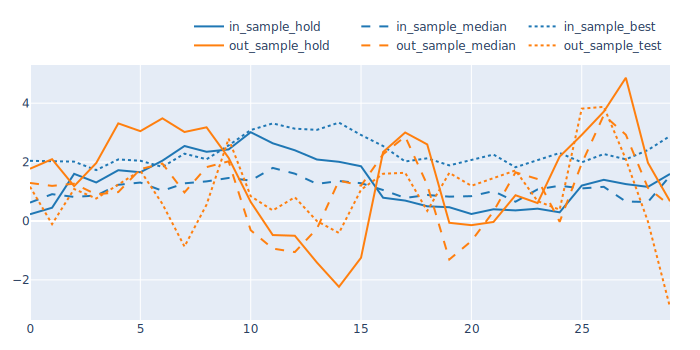

In [23]:
color_schema = vbt.settings['plotting']['color_schema']

cv_results_df.vbt.plot(
    trace_kwargs=[
        dict(line_color=color_schema['blue']),
        dict(line_color=color_schema['blue'], line_dash='dash'),
        dict(line_color=color_schema['blue'], line_dash='dot'),
        dict(line_color=color_schema['orange']),
        dict(line_color=color_schema['orange'], line_dash='dash'),
        dict(line_color=color_schema['orange'], line_dash='dot')
    ]
).show_svg()